In [28]:
#!/usr/bin/env python
# coding: utf-8
# Author: Nelson Fernandez, Renault Research
# nelson.fernandez-pinto@renault.com

import sys,os
sys.path.append(os.getcwd())

# Imports
from dataset import *
from architectures import *
from functions import *
from losses import *
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.autograd import Variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(17)


# Generate dataset
me = MazeExplorer(maze_size=(64,64), nbr_instances=10, 
                  difficulty='easy', nbr_trajectories=20,
                  alpha=17)


# Show dopping percentages
#me.get_dopping_percentage()  # point level
#me.get_dopping_percentage_trajectories() # trajectory level


# Create CNN model
net = ConvNet().to(device)
print('CNN created...')


# Get set of train/test INDEXES (hacking SKlean train_test_split)
x = np.arange(0, me.len())
train_indexes, test_indexes, _, _ = train_test_split(x, x, 
                                                    test_size=0.33, 
                                                    random_state=7)


# Wrap transforming function to dataset object
t_me = TransformedDataset(me, xy_transform=xy_transform)

# Get training/test subsets
train_me = Subset(t_me, indices=train_indexes)
test_me = Subset(t_me, indices=test_indexes)

# Configure dataloaders
batch_size = 10
num_workers = 4

trainloader = DataLoader(train_me, shuffle=True, 
                          batch_size=batch_size, 
                          num_workers=num_workers, 
                          pin_memory=True)


testloader = DataLoader(test_me, shuffle=True, 
                         batch_size=batch_size, 
                         num_workers=1,
                         pin_memory=True)

print('Train test data loaders created...')

# Init losses
rmse = RMSELoss()
graphic_loss = GraphicLoss()

# Set optimizer (Adam)
optimizer = Adam(net.parameters(), lr=1e-3)
epochs = 200
print('Losses and optimizer created...')


100%|██████████| 10/10 [00:00<00:00, 999.71it/s]

Creating MazeExplorer dataset of difficulty easy
Using Prims generator
Using shortest path solver


Dataset generated... 220 available instances
CNN created...
Train test data loaders created...
Losses and optimizer created...


In [34]:


net.train()
print('Init training loop...')
loss_dict = []

for epoch in range(1, epochs+1):
    iters = 0.0
    total_env = 0.0
    total_rmse = 0.0
    for batch_idx, (data, target, path, goals, expert_flag) in enumerate(trainloader):
        # Convert X, Y to Torch variables
        grid = data   # save numpy version of maze grid

        # Convert input and target to tensors
        data, target = Variable(data), Variable(target)
        data, target = data.to(device).float(), target.to(device).float()
 
        # Set gradient to zero
        optimizer.zero_grad()

        # Get network output
        output = net(data)

        # RMSE Loss
        #loss = mse(output, target)
        # Compute total loss (RMSE + Env)
        #loss = total_loss(rmse, graphic_loss, grid, path, goals, output, target, env=True)

        rmse_loss = rmse(output, target)
        # non-expert trajectory (environment).detach().numpy()
        # Maze walls loss (target, prediction) / Convert to numpy arrays
        
        #grid = grid[0][0].detach().numpy()
        #path = path[0].detach().numpy()
        #goals = goals[0].detach().numpy()
        #output = output[0].detach().cpu().numpy()

        # Reconstruct predicted grids
        pred_grid = torch.tensor(draw_solution_canvas(grid, output)).double().to(device)
        pred_path = torch.tensor(draw_solution_canvas(path, output)).double().to(device)
        pred_goals = torch.tensor(draw_goals_canvas(grid, output)).double().to(device)

        # Compute graphic losses
        # Wall loss
        wall_loss = graphic_loss(torch.tensor(grid).to(device), pred_grid)
        # Path planning loss 
        path_loss = graphic_loss(torch.tensor(path).to(device), pred_path)
        #path_loss = abs(wall_loss-path_loss)
        # Goals loss
        goal_loss = graphic_loss(torch.tensor(goals).to(device), pred_goals)

        # Final non-expert trajectory loss
        env_loss = Variable((wall_loss + path_loss + goal_loss), requires_grad=True)/10 #
        loss = env_loss + rmse_loss
    
        #print('env loss', env_loss)
        #print('rmse loss', rmse_loss)

        # Backpropagate loss & udpate gradient
        loss.backward()
        optimizer.step()
        
        #if epoch == 20:
        #    break
        
        # Print information
        iters += loss
        total_env+= env_loss
        total_rmse+= rmse_loss
        
        #print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
        #        epoch, batch_idx, len(trainloader.dataset),
        #        100. * (batch_idx) / len(trainloader), iters/len(trainloader)), end='\r', flush=True)
    #print("")
    

        print('Train Epoch: {} [{}/{} ({:.0f}%)] EnvLoss: {:.6f}  RMSELoss: {:.6f} TotalLoss: {:.6f}'.format(
                epoch, batch_idx, len(trainloader.dataset),
                100. * (batch_idx) / len(trainloader), 
                total_env/len(trainloader), 
                total_rmse/len(trainloader),
                iters/len(trainloader)
                ), 
                
                end='\r', flush=True)
    print("")
    loss_dict.append([total_env/len(trainloader), 
                      total_rmse/len(trainloader), 
                      iters/len(trainloader)])
                                 

Init training loop...


ValueError: too many values to unpack (expected 2)

In [3]:
def plot_losses(losses):
    t_en = []
    t_rm = []
    t_to = []
    for element in losses:
        en, rm, total = element
        t_en.append(en)
        t_rm.append(rm)
        t_to.append(total)
    plt.figure(figsize=(14,5))
    plt.plot(range(len(t_en)), t_en, label='env losses')
    plt.plot(range(len(t_en)), t_rm, label='rmse loss')
    plt.plot(range(len(t_en)), t_to, label='total loss')
    plt.title('Train loss')
    plt.legend()


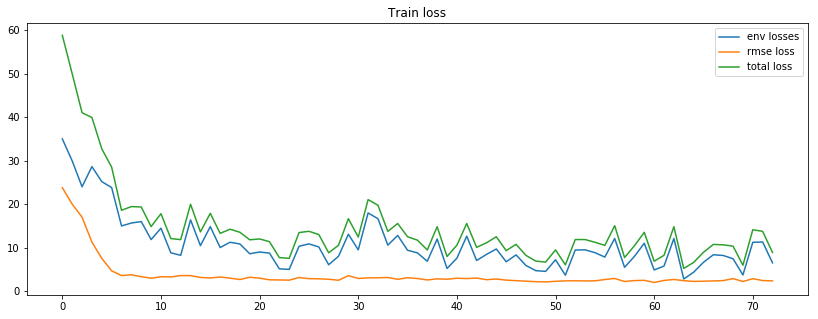

In [30]:
plot_losses(loss_dict)

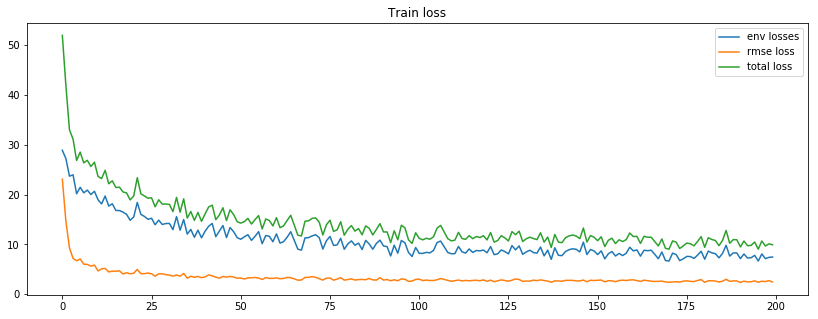

In [5]:
plot_losses(loss_dict)

Text(0.5, 1.0, 'target')

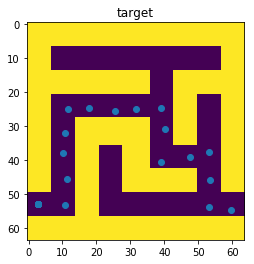

In [6]:
plt.imshow(grid.T)
plt.scatter(target[0][:,0], target[0][:,1])
plt.title('target')

Text(0.5, 1.0, 'prediction')

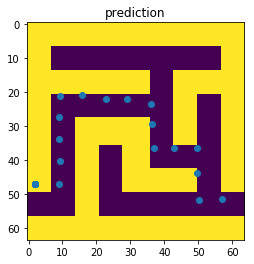

In [7]:
plt.imshow(grid.T)
plt.scatter(output[:,0], output[:,1])
plt.title('prediction')

Text(0.5, 1.0, 'prediction')

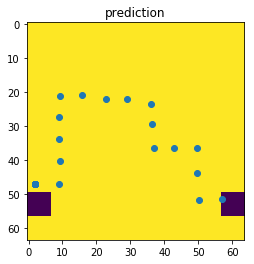

In [8]:
plt.imshow(goals.T)
plt.scatter(output[:,0], output[:,1])
plt.title('prediction')

In [9]:
pred_grid = torch.tensor(draw_solution_canvas(grid, output)).double().to(device)

# Compute graphic losses
# Wall loss
wall_loss = graphic_loss(torch.tensor(grid).to(device), pred_grid)
        

In [10]:
wall_loss

tensor(62., device='cuda:0')

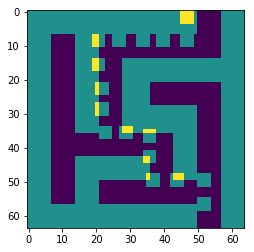

In [11]:
add_grid = torch.add(torch.tensor(grid).to(device), pred_grid.t())
plt.imshow(add_grid)

In [12]:
torch.sum(add_grid > 1.).float()

tensor(62., device='cuda:0')

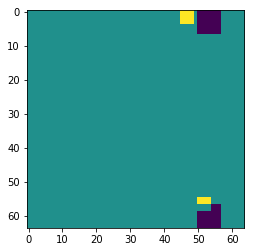

In [13]:
goal_grid = torch.tensor(draw_goals_canvas(goals, output)).double().to(device)
add_grid4 = torch.add(torch.tensor(goals).to(device), goal_grid.t())
plt.imshow(add_grid4)

In [14]:
torch.sum(add_grid4 > 1.).float()

tensor(24., device='cuda:0')

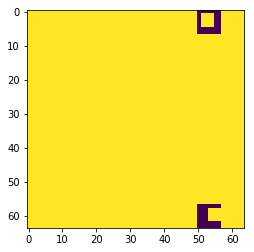

In [15]:
goal_grid = torch.tensor(draw_goals_canvas(goals, target[0])).double().to(device)
add_grid3 = torch.add(torch.tensor(goals).to(device), goal_grid.t())
plt.imshow(add_grid3)

In [16]:
torch.sum(add_grid3 > 1.).float()

tensor(0., device='cuda:0')

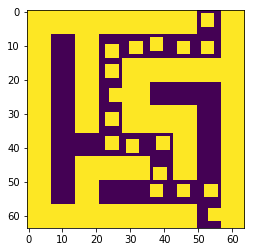

In [17]:
pred_target = torch.tensor(draw_solution_canvas(grid, target[0])).double().to(device)

add_grid2 = torch.add(torch.tensor(grid).to(device), pred_target.t())

plt.imshow(add_grid2)

In [18]:
torch.sum(add_grid2 > 1.).float()

tensor(0., device='cuda:0')

In [19]:
goal_loss

tensor(24., device='cuda:0')

tensor(72., device='cuda:0')

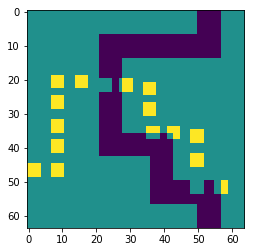

In [20]:
add_grid = torch.add(torch.tensor(path).to('cuda'), pred_path)
plt.imshow(add_grid.detach().cpu().numpy())
graphic_loss(torch.tensor(path).to(device), torch.tensor(pred_path).double().to(device))

In [21]:
add_grid = torch.add(torch.tensor(path
                                 ).to('cuda'), pred_path.t())
torch.sum(add_grid > 1.).float()

tensor(72., device='cuda:0')

In [22]:
add_grid.min()

tensor(0., device='cuda:0', dtype=torch.float64)

tensor(62., device='cuda:0')

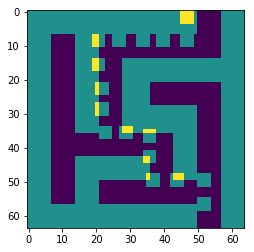

In [23]:
add_grid2 = torch.add(torch.tensor(grid).to('cuda'), pred_grid.t())
plt.imshow(add_grid2.detach().cpu().numpy())
graphic_loss(torch.tensor(grid).to(device), torch.tensor(pred_grid).double().to(device))

tensor(24., device='cuda:0')

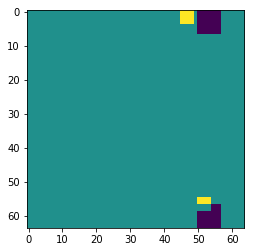

In [24]:
add_grid = torch.add(torch.tensor(goals).to('cuda'), pred_goals.t())
plt.imshow(add_grid.detach().cpu().numpy())
graphic_loss(torch.tensor(goals).to(device), torch.tensor(pred_goals).double().to(device))

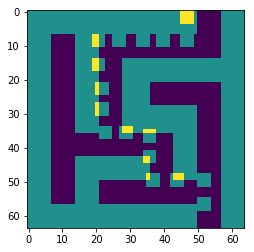

In [25]:
add_grid = torch.add(torch.tensor(grid).to('cuda'), pred_grid.t())

plt.imshow(add_grid.detach().cpu().numpy())

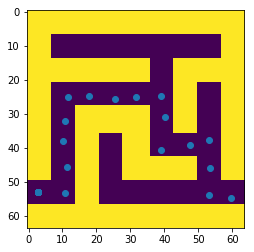

In [26]:
plt.imshow(grid.T)
plt.scatter(target[0][:,0], target[0][:,1])

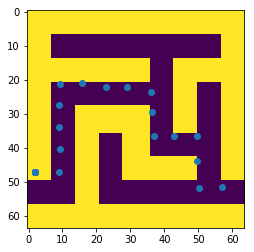

In [27]:
plt.imshow(grid.T)
plt.scatter(output[:,0], output[:,1])

## Vectorize losses

In [66]:
data.shape

torch.Size([10, 1, 64, 64])

In [67]:
target.shape

torch.Size([10, 50, 2])

In [68]:
grid.shape

torch.Size([10, 1, 64, 64])

In [69]:
goals.shape

torch.Size([10, 64, 64])

In [70]:
path.shape

torch.Size([10, 64, 64])

In [ ]:
class GraphicLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, target, prediction):     
        add_grid = torch.add(target, prediction.t())
        return torch.sum(add_grid > 1.).float()


In [73]:
grid.shape

torch.Size([10, 1, 64, 64])

In [59]:
# Get solution canvas for each element in batch
h = [draw_solution_canvas(x[0],y) for x in grid for y in target]
h = torch.tensor(h)

In [64]:
l = [graphic_loss(y_true, y_pred) for y_true in grid for y_pred in h]

In [76]:
l = torch.tensor(l)

In [78]:
l.mean()

tensor(49.3200)

In [74]:
l/16

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [54]:
torch.tensor(h).shape

torch.Size([100, 64, 64])

In [ ]:
a = torch.arange(0,8).view(-1,2,2)
b = [t.inverse() for t in torch.functional.unbind(a)]
c = torch.functional.stack(b)-

In [ ]:
class GraphicLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, target, prediction):
        add_grid = torch.add(target, prediction.t())
        return torch.sum(add_grid > 1.).float()


In [58]:
grid.shape

torch.Size([10, 1, 64, 64])

In [60]:
h.shape

torch.Size([100, 64, 64])

In [57]:
graphic_loss(grid, torch.tensor(h))

RuntimeError: t() expects a 2D tensor, but self is 3D

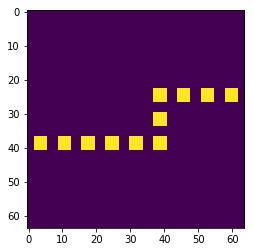

In [47]:
plt.imshow(l[9])

In [ ]:
grid = grid[0][0].detach().numpy()
path = path[0].detach().numpy()
goals = goals[0].detach().numpy()
output = output[0].detach().cpu().numpy()

# Reconstruct predicted grids
pred_grid = torch.tensor(draw_solution_canvas(grid, output)).double().to(device)
pred_path = torch.tensor(draw_solution_canvas(path, output)).double().to(device)
pred_goals = torch.tensor(draw_goals_canvas(grid, output)).double().to(device)

# Compute graphic losses
# Wall loss
wall_loss = graphic_loss(torch.tensor(grid).to(device), pred_grid)
# Path planning loss 
path_loss = graphic_loss(torch.tensor(path).to(device), pred_path)
#path_loss = abs(wall_loss-path_loss)
# Goals loss
goal_loss = graphic_loss(torch.tensor(goals).to(device), pred_goals)

# Final non-expert trajectory loss
env_loss = Variable((wall_loss + path_loss + goal_loss), requires_grad=True)/10 #
loss = env_loss + rmse_loss
    